In [1]:
import scipy as sc
import matplotlib.pylab as PLT
import numpy as np

import F2O.constants as CTE

import F2O.F2O_utils as F2O
from fwOp.fwOperator import fwOp

from F2O.F2O_sptl import gd
from F2O.AA_sptl import AA_gd

import demo.synthData as sd


# If you get an error while loading the F2O, then
# 
# * Exit Jupyter
# * Go to the F2O root dir, and execute
#      export PYTHONPATH=$PYTHONPATH:`pwd`
# * Relaunch Jupyter
#

# Simple quadratic optimization problem

### Generate data

In [2]:
N = 2000

synthData = sd.synthData()

A, b, xori = synthData.genData(N, 1.*N)


> $\large \begin{array}{rcl}
 B & = & \mbox{randn}(N,N) \\
 A & = & B^TB + \alpha\cdot\mbox{diag}(N) \\
 & \\
 \mathbf{x}_{\tiny\mbox{ORI}} & = & \mbox{randn}(N,1) \\
 & \\
 b & = & A\mathbf{x}_{\tiny\mbox{ORI}} + \sigma\cdot \mbox{randn}(N,1) 
\end{array}$


### Define optimization variable

In [3]:
args = F2O.argsF2O()

args.verbose    = True
args.fCostClass = CTE.cost_L2_lin      # F(x) = 0.5|| fAx(x) - b ||_2^2, where fAx is lineal
args.freqSol    = False                         


### Select forward operator 

In [4]:
Op       = fwOp()
Op.linOp = CTE.fAx_matrixvec
Op.A     = A
  


args.bShape    = b.shape
args.hShape    = A.shape


# Solve $F(\mathbf{x}) = 0.5|| \mbox{Op}(\mathbf{x}) - \mathbf{b} ||_2^2$ via GD 

$$ \large
\begin{array}{l}
\begin{array}{rcl}
\mbox{Init :} & & \mathbf{x}_0  - \mbox{ Initial solution}\\
 & & p_\alpha - \mbox{ Compute step-size (simplest case: } \alpha = \mbox{cte.)}\\
 & \\
\end{array} \\
\mathbf{\mbox{for }} k = 0,1,\ldots \\
 \quad \mathbf{g}_k = \nabla F(\mathbf{x}_k) \\
 \quad \alpha_k = p_\alpha(\cdot) \\
 \quad \mathbf{x}_{k+1} = \mathbf{x}_k - \alpha_k\cdot \mathbf{g}_k
\end{array} 
$$

Python code (see  ` F2O_sptl.py ` )

```python
for k in range(nIter):   
    
    grad = computeGrad(x, b, None)
    
    gd.RecordStats(k, x, b, grad, gdStats, None, computeCost)   # --- statistics --
                    
    alpha = computeSS(k, grad, x)       # compute step-size
    
    x = x - alpha*grad                  # Gradient descent step
    
    gdStats[k,1] = alpha                # --- record step-Size ---
        
    if stopFunc(k, x, gdStats):         # check for exit condition / print stats
      print('Stop criteria -- iteration {0}'.format(k))
      break
```

### (1) along with a constant step-size

In [5]:
ssCte = 2.5e-9
nIter = 100

# Comment the next command out to avoid printing the cost function evolution
args.verbose   = False

args.ssPoliciy = CTE.ss_Cte
args.ssCte     = ssCte
x0, gdStats0   = gd(Op, b, nIter, args)


### (2) along with the BB (Barzilai-Borwein) step-size

In [10]:

args.ssPoliciy = CTE.ss_BBv1
args.ssCte     = 0.0
x1, gdStats1   = gd(Op, b, nIter, args)


Stop criteria -- iteration 30


### (3) along with the Anderson Acceleration

In [7]:
args.ssPoliciy = CTE.ss_AA
args.ssCte     = 0
args.nGrad     = 4
x2, gdStats2   = AA_gd(Op, b, nIter, args)


Stop criteria -- iteration 55


### Plot cost functional evolution vs. iteration

Text(0.5, 1.0, '\n Step-size vs. iteration')

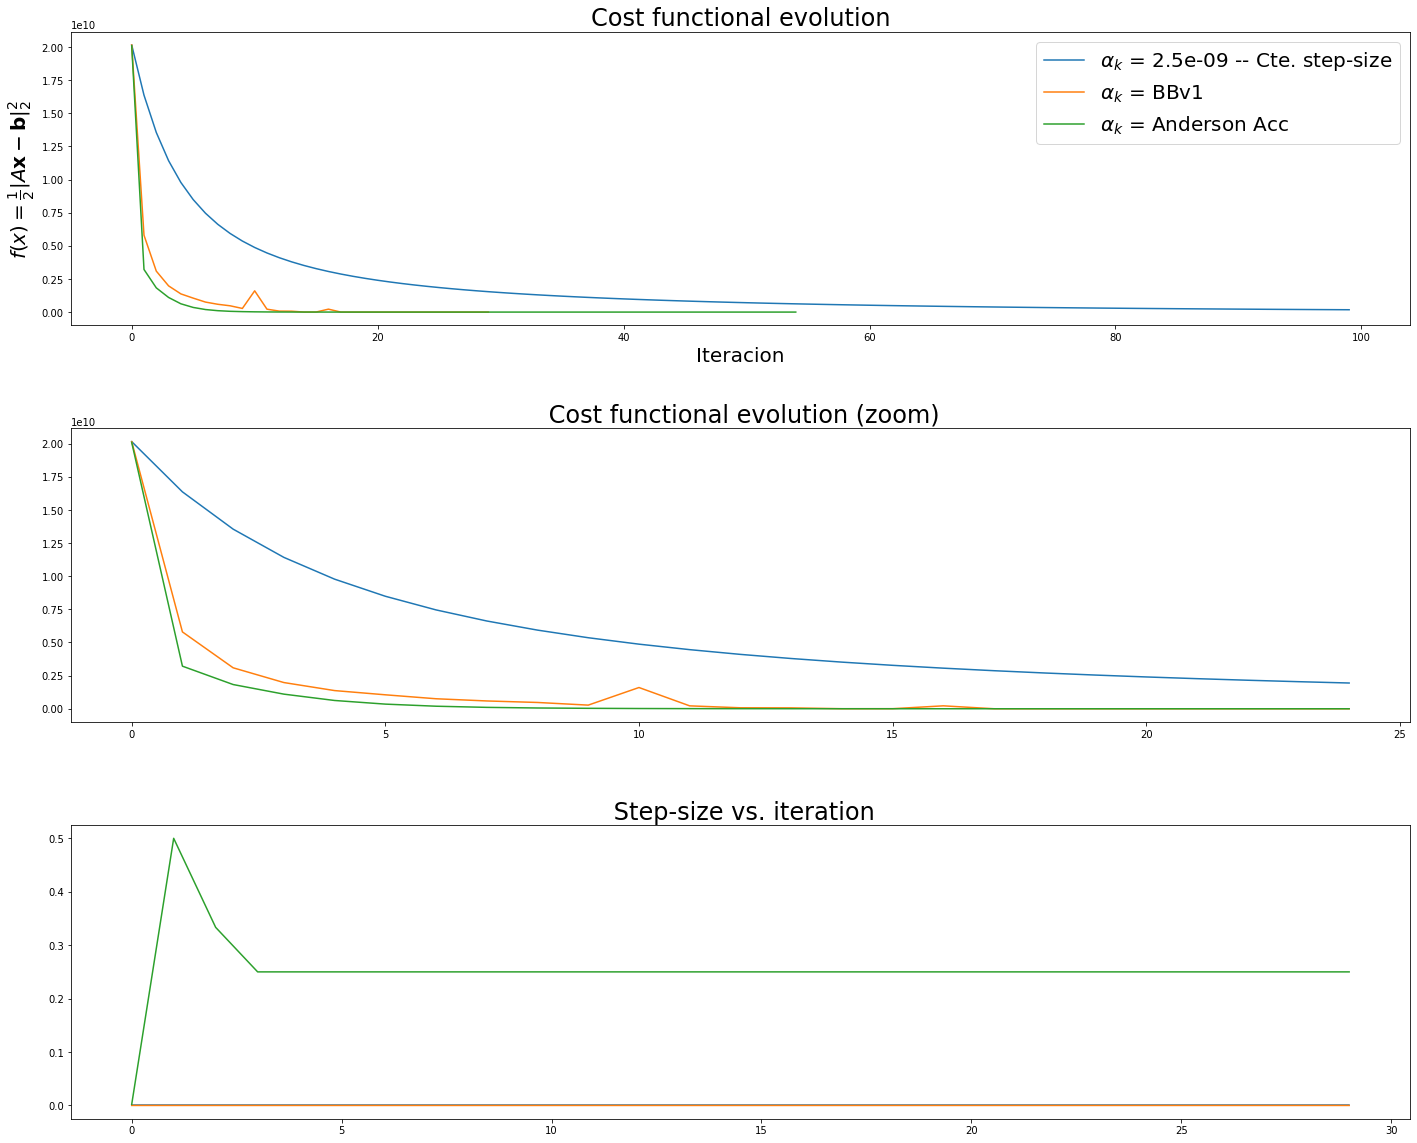

In [11]:


fig = PLT.figure(figsize=(24, 20))

ax1 = fig.add_subplot(3, 1, 1)


PLT.plot(gdStats0[:,0], label=r'$\alpha_k$ = {0} -- {1}'.format(ssCte, CTE.ss_list[CTE.ss_Cte]) )
PLT.plot(gdStats1[:,0], label=r'$\alpha_k$ = {0}'.format(CTE.ss_list[CTE.ss_BBv1]))
PLT.plot(gdStats2[:,0], label=r'$\alpha_k$ = {0}'.format(CTE.ss_list[CTE.ss_AA]))
PLT.legend(loc='upper right',fontsize=20)
PLT.ylabel(r'$f(x) = \frac{1}{2}\| A \mathbf{x} - \mathbf{b} \|_2^2$',fontsize=20)
PLT.xlabel('Iteracion',fontsize=20)
PLT.title('Cost functional evolution',fontsize=24)
PLT.subplots_adjust(hspace = 0.35)

ax1 = fig.add_subplot(3, 1, 2)
PLT.plot(gdStats0[0:25,0], label=r'$\alpha_k$ = {0} -- {1}'.format(ssCte, CTE.ss_list[CTE.ss_Cte]) )
PLT.plot(gdStats1[0:25,0], label=r'$\alpha_k$ = {0}'.format(CTE.ss_list[CTE.ss_BBv1]))
PLT.plot(gdStats2[0:25,0], label=r'$\alpha_k$ = {0}'.format(CTE.ss_list[CTE.ss_AA]))
PLT.title('\n Cost functional evolution (zoom)',fontsize=24)


ax1 = fig.add_subplot(3, 1, 3)
PLT.plot(gdStats0[0:30,1], label=r'$\alpha_k$ = {0} -- {1}'.format(ssCte, CTE.ss_list[CTE.ss_Cte]) )
PLT.plot(gdStats1[0:30,1], label=r'$\alpha_k$ = {0}'.format(CTE.ss_list[CTE.ss_BBv1]))
PLT.plot(gdStats2[0:30,1], label=r'$\alpha_k$ = {0}'.format(CTE.ss_list[CTE.ss_AA]))
PLT.title('\n Step-size vs. iteration',fontsize=24)



### Plot cost functional evolution vs. Time

Text(0.5, 1.0, '\n Cost functional evolution (zoom)')

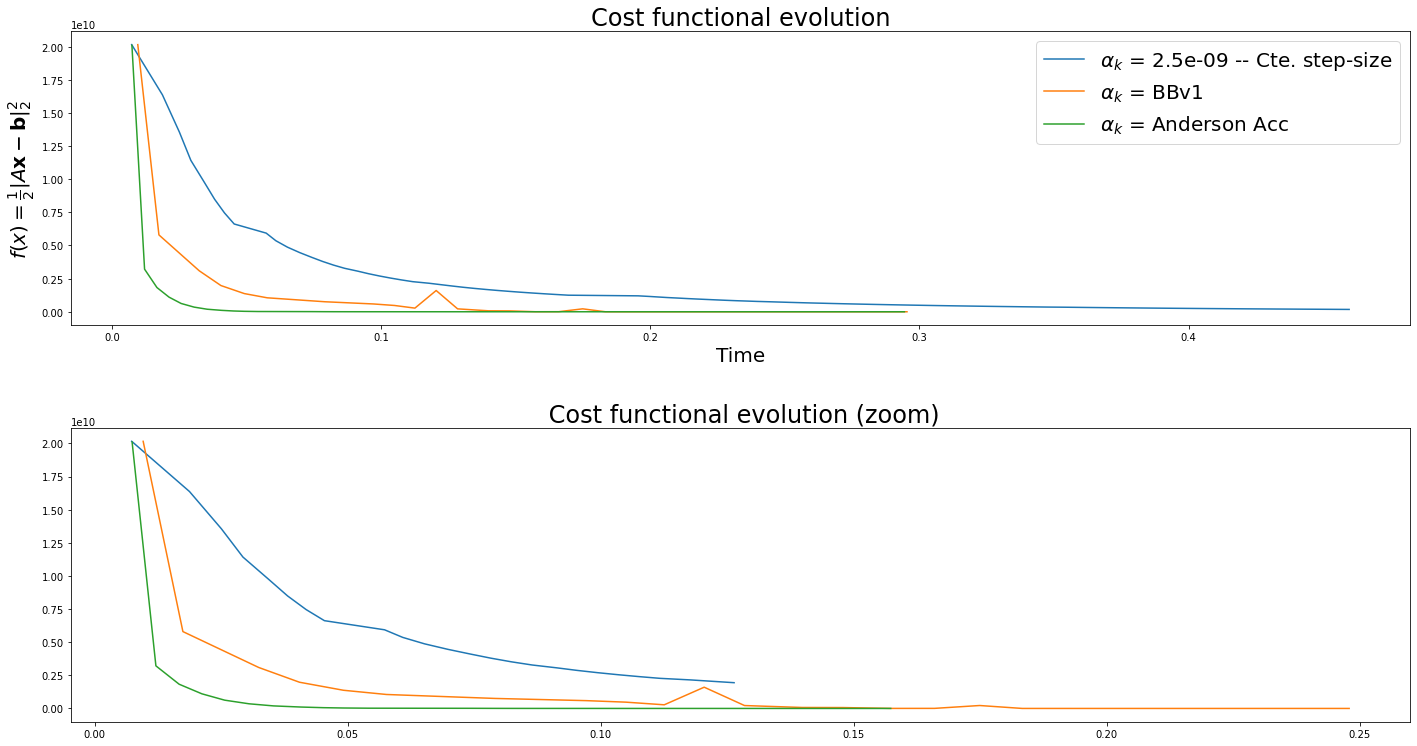

In [12]:

fig = PLT.figure(figsize=(24, 20))

ax1 = fig.add_subplot(3, 1, 1)


PLT.plot(gdStats0[:,2], gdStats0[:,0], label=r'$\alpha_k$ = {0} -- {1}'.format(ssCte, CTE.ss_list[CTE.ss_Cte]) )
PLT.plot(gdStats1[:,2], gdStats1[:,0], label=r'$\alpha_k$ = {0}'.format(CTE.ss_list[CTE.ss_BBv1]))
PLT.plot(gdStats2[:,2], gdStats2[:,0], label=r'$\alpha_k$ = {0}'.format(CTE.ss_list[CTE.ss_AA]))
PLT.legend(loc='upper right',fontsize=20)
PLT.ylabel(r'$f(x) = \frac{1}{2}\| A \mathbf{x} - \mathbf{b} \|_2^2$',fontsize=20)
PLT.xlabel('Time',fontsize=20)
PLT.title('Cost functional evolution',fontsize=24)
PLT.subplots_adjust(hspace = 0.35)

ax1 = fig.add_subplot(3, 1, 2)
PLT.plot(gdStats0[0:25,2], gdStats0[0:25,0], label=r'$\alpha_k$ = {0} -- {1}'.format(ssCte, CTE.ss_list[CTE.ss_Cte]) )
PLT.plot(gdStats1[0:25,2], gdStats1[0:25,0], label=r'$\alpha_k$ = {0}'.format(CTE.ss_list[CTE.ss_BBv1]))
PLT.plot(gdStats2[0:25,2], gdStats2[0:25,0], label=r'$\alpha_k$ = {0}'.format(CTE.ss_list[CTE.ss_AA]))
PLT.title('\n Cost functional evolution (zoom)',fontsize=24)

